# Capstone Project: Predicting NHL Player Salary

## Part III - Modeling

Author: Charles Ramey

Date: 05/15/2023

---

#### Notebook Links

Part I - Project Intro & Data Cleaning
- [`Part-1_setup-and-cleaning.ipynb`](../code/Part-1_setup-and-cleaning.ipynb)

Part II - Exploratory Data Analysis (EDA)
- [`Part-2_eda.ipynb`](../code/Part-2_eda.ipynb)

Part III - Modeling
- [`Part-3.2_modeling-defense.ipynb`](../code/Part-3.2_modeling-defense.ipynb)
- [`Part-3.3_modeling-goalies.ipynb`](../code/Part-3.3_modeling-goalies.ipynb)

Part IV - Conclusion, Recommendations, and Sources
- [`Part-4_conclusion-and-recommendations.ipynb`](../code/Part-4_conclusion-and-recommendations.ipynb)

### Contents

- [Data Import and Preprocessing](#Data-Import-and-Cleaning)
- [Modeling](#Modeling)

### Library Imports

In [16]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
import xgboost as xg
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict, GridSearchCV

from sklearn.metrics import mean_squared_error
import pickle
import warnings

## Data Import and Preprocessing

### Data Import

In [2]:
forwards = pd.read_csv('../data/forwards_cleaned.csv')

In [3]:
forwards.head(2)

,player,pos,contract_aav,season,pct_change,upper_limit,lower_limit,min_salary,team,games_played,...,xgoals_on_rebounds_shots,share_of_xgoals_from_rebounds_shots,xgoals_from_non_rebounds,xgoals_of_expected_rebounds,created_xgoals,created_xgoals_minus_actual_xgoals,shooting_talent_above_average,shooting_talent_adjusted_expected_goals,goals_above_shooting_talent,final_standing
0,Dana Tyrell,F,600000,2010-11,0.0825,64300000,48300000,525000,TBL,78.0,...,0.9,0.129,6.2,1.0,7.2,0.1,0.0,7.1,-1.1,8.0
1,Kyle Turris,F,1400000,2010-11,0.0825,64300000,48300000,525000,ARI,65.0,...,1.7,0.163,8.5,1.6,10.0,-0.1,0.0,10.1,0.9,11.0


### Preprocessing

Recall that in the Part I, we reordered the features for our 2022-23 data that will be used for the app deployment when predicting 2023-24 salaries. Here we need to apply the same transformation to the data we are training the model on. This way, when the 2023 data is fed through the model, all of the features will be in the same order.

In [4]:
ordered_columns = sorted(forwards.columns)
forwards = forwards.reindex(columns=ordered_columns)

In [5]:
forwards.head(2)

,assists,assists_per_60_minutes,contract_aav,created_xgoals,created_xgoals_minus_actual_xgoals,defensive_zone_giveaways,expected_goals,expected_goals_per_60_minutes,expected_pct_of_unblocked_shots_that_missed_net,expected_shooting_pct_on_unblocked_shots,...,shots_on_goal_per_60_minutes,shots_that_missed_net,shots_that_were_blocked,takeaways,team,upper_limit,xgoals_from_non_rebounds,xgoals_of_expected_rebounds,xgoals_on_rebounds_shots,xrebounds_created
0,9.0,0.57,600000,7.2,0.1,10.0,7.1,0.45,0.286,0.071,...,4.66,25.0,20.0,21.0,TBL,64300000,6.2,1.0,0.9,4.8
1,14.0,1.15,1400000,10.0,-0.1,3.0,10.1,0.83,0.273,0.067,...,9.50,34.0,36.0,14.0,ARI,64300000,8.5,1.6,1.7,7.7


For this project, we are going to train the model on data from the 2010-11 season through the 2019-20 season and then test it on data from the 2020-21 and 2021-22 seasons as if these were seasons we didn't yet have data for. This will give us a more realistic idea of how the model will translate to future seasons.

In [6]:
forwards_train = forwards[~forwards['season'].isin(['2020-21', '2021-22'])]
forwards_test = forwards[forwards['season'].isin(['2020-21', '2021-22'])]

---
## Modeling

Now we need to split the train and test datasets into the independent and target variables, X and y, where X contains all of the features we will train the model on and y contains the target, `contract_aav`.

In [7]:
X_train = forwards_train.drop(columns=['player', 'pos', 'team', 'season', 'contract_aav'], axis=1)
y_train = forwards_train['contract_aav']

X_test = forwards_test.drop(columns=['player', 'pos', 'team', 'season', 'contract_aav'], axis=1)
y_test = forwards_test['contract_aav']

Since the scale of our variables varies widely, we need to scale the data by passing it through a StandardScaler.

In [8]:
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

We'll start with a simple linear regression model to get a sort of baseline.

In [9]:
# Initiate the model
lr = LinearRegression()

# Fit the model to the training data
lr.fit(Xs_train, y_train)

# Score the model's performance one the train and test data
lr.score(Xs_train, y_train), lr.score(Xs_test, y_test)

(0.8386941067410609, 0.6630881101035926)

In [18]:
# Initiate the model
lasso = LassoCV(alphas = np.logspace(0.001, 10, 1), max_iter=10_000)

# Fit the model to the training data
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lasso.fit(Xs_train, y_train)

# Score the model's performance one the train and test data
lasso.score(Xs_train, y_train), lasso.score(Xs_test, y_test)

(0.8359835148751705, 0.6711480651115064)

The basic linear regression model performs okay, however it is somewhat overfit to the training data. One explanation for this is that we have a large number of features, many of which we expect to be collinear to some degree. For example, points are directly calculated by adding goals and assists. One option for handling data with a lot of features and high potential for multicollinearity is to perform a principal component analysis (PCA). This will help us reduce the dimensionality of the data by keying in on the variables that most explain the variation in the target variable.

We'll use a gridsearch to test the `n_components` parameter of the PCA transformation which will determine the degree to which the dataset's dimensionality is reduced.

In [11]:
# Define the pipeline
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('pc', PCA()),
    ('lr', LinearRegression())
])

# Define a parameter grid to search over
pgrid = {'pc__n_components' : np.arange(1, 40)}

# Instantiate the gridsearch
gs = GridSearchCV(pipe, pgrid, cv = 5, n_jobs=-1)

# Fit the model with the best parameters
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()), ('pc', PCA()),
                                       ('lr', LinearRegression())]),
             n_jobs=-1,
             param_grid={'pc__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])})

In [12]:
# Score the model's performance one the train and test data
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.7283299833028327, 0.5790809107800308)

After adding in the PCA, we were able to reduce some of the overfitting. However, linear regression isn't the only model we have in the bag. Let's test a few others and compare the results.

In [13]:
# Instantiation of models to test

# Logisitic Regression
lr = LinearRegression()

# Decision Tree Regressor
dt = DecisionTreeRegressor()

# Random Forest Regressor
rf = RandomForestRegressor()

# Extra Trees Regressor
et = ExtraTreesRegressor()

# Adaptive Boost Regressor
ada = AdaBoostRegressor()

# Extreme Gradient Boost Regressor
xgb = xg.XGBRegressor()

In [14]:
# Define the parameter grids to search over for each model
lr_params = {
    'pc__n_components' : np.arange(1, 40)
}

dt_params = {
    'pc__n_components' : np.arange(1, 40),
    'dt__max_depth': [3,5],
    'dt__min_samples_split': [2,5,10],
    'dt__random_state': [42]}

rf_params = {
    'pc__n_components' : np.arange(1, 40),
    'rf__max_depth': [3,5],
    'rf__min_samples_split': [2,5,10],
    'rf__random_state': [42]}
    
et_params = {
    'pc__n_components' : np.arange(1, 40),
    'et__n_estimators': [50,100],
    'et__max_depth': [3,5],
    'et__min_samples_split': [2,5,10],
    'et__random_state': [42]}

ada_params = {
    'pc__n_components' : np.arange(1, 40),
    'ada__n_estimators': [50,100],
    'ada__learning_rate': [0.3,0.6],
    'ada__random_state': [42]}

xgb_params = {
    'pc__n_components' : np.arange(1, 40),
    'xgb__n_estimators': [50,100],
    'xgb__learning_rate': [0.3,0.6],
    'xgb__random_state': [42]}

In [15]:
'''
Code adapted from Devin Faye, General Assembly
'''
def evaluation(X_train, y_train, X_test, y_test, model, model_name:str,
               model_params, scores_df=None):
    # If this is the first call of this function and a previous dataframe of scores
    # is not passed in the parameters, define a new dataframe to store model metrics
    if scores_df is None:
        scores_df = pd.DataFrame(columns = ['train_score', 'test_score', 'difference', 'rmse ($)'])

    # Create a pipeline that will scale the data, perform a PCA, and feed it into the selected model
    pipe = Pipeline([
        ('ss', StandardScaler()),
        ('pc', PCA(random_state=42)),
        (model_name, model)])
    
    # Instantiate a grid search to pass the pipeline into with hyperparameters to search over
    gs = GridSearchCV(
        pipe,
        model_params,
        cv = 5, n_jobs=-1)
    
    # Fit the model to the training data
    gs.fit(X_train, y_train)
   
    # Print out the best hyperparameters for this model
    print(f"The best parameters for the {model_name} model are: {gs.best_params_}")
    
    # Store the model's predicted values
    preds = gs.predict(X_test)
    
    # Score the model's performance on the training and testing data
    train_score = round(gs.score(X_train, y_train), 2)
    test_score = round(gs.score(X_test, y_test), 2)
    difference = round(train_score - test_score, 2)
    rmse = int(mean_squared_error(y_test, preds, squared=False))
    
    # Store the scores in the dataframe
    scores_df.loc[model_name,:] = [train_score, test_score, difference, rmse]
    # Make sure the scores are being stored as a dataframe
    scores_df = pd.DataFrame(scores_df)
    
    print('')
    print(scores_df)
    
    return scores_df

In [16]:
scores = evaluation(X_train, y_train, X_test, y_test, lr, 'lr',
                    lr_params)

The best parameters for the lr model are: {'pc__n_components': 22}

   train_score test_score difference rmse ($)
lr        0.73       0.58       0.15  1556843


These results are nothing new, but we'll store them in the `scores_df` to easily compare them side by side with the other models. All results will be interpreted below.

In [17]:
scores = evaluation(X_train, y_train, X_test, y_test, dt, 'dt',
                    dt_params, scores_df=scores)

The best parameters for the dt model are: {'dt__max_depth': 3, 'dt__min_samples_split': 2, 'dt__random_state': 42, 'pc__n_components': 1}

   train_score test_score difference rmse ($)
lr        0.73       0.58       0.15  1556843
dt        0.72        0.5       0.22  1701415


In [18]:
scores = evaluation(X_train, y_train, X_test, y_test, rf, 'rf',
                    rf_params, scores_df=scores)

The best parameters for the rf model are: {'pc__n_components': 10, 'rf__max_depth': 5, 'rf__min_samples_split': 2, 'rf__random_state': 42}

   train_score test_score difference rmse ($)
lr        0.73       0.58       0.15  1556843
dt        0.72        0.5       0.22  1701415
rf        0.89       0.55       0.34  1605023


In [19]:
scores = evaluation(X_train, y_train, X_test, y_test, et, 'et',
                    et_params, scores_df=scores)

The best parameters for the et model are: {'et__max_depth': 5, 'et__min_samples_split': 5, 'et__n_estimators': 50, 'et__random_state': 42, 'pc__n_components': 32}

   train_score test_score difference rmse ($)
lr        0.73       0.58       0.15  1556843
dt        0.72        0.5       0.22  1701415
rf        0.89       0.55       0.34  1605023
et         0.8       0.55       0.25  1615605


In [20]:
scores = evaluation(X_train, y_train, X_test, y_test, ada, 'ada',
                    ada_params, scores_df=scores)

The best parameters for the ada model are: {'ada__learning_rate': 0.3, 'ada__n_estimators': 50, 'ada__random_state': 42, 'pc__n_components': 39}

    train_score test_score difference rmse ($)
lr         0.73       0.58       0.15  1556843
dt         0.72        0.5       0.22  1701415
rf         0.89       0.55       0.34  1605023
et          0.8       0.55       0.25  1615605
ada        0.84       0.55       0.29  1611526


In [21]:
scores = evaluation(X_train, y_train, X_test, y_test, xgb, 'xgb',
                    xgb_params, scores_df=scores)

The best parameters for the xgb model are: {'pc__n_components': 8, 'xgb__learning_rate': 0.3, 'xgb__n_estimators': 100, 'xgb__random_state': 42}

    train_score test_score difference rmse ($)
lr         0.73       0.58       0.15  1556843
dt         0.72        0.5       0.22  1701415
rf         0.89       0.55       0.34  1605023
et          0.8       0.55       0.25  1615605
ada        0.84       0.55       0.29  1611526
xgb         1.0       0.45       0.55  1779651


Despite the power of some of these other models, the linear regression performs the best. While it doesn't have the best score on the training data, it does perform the best on the test data with the lowest variance, meaning it will generalize the best to new player data. It also has the lowest root mean squared error (RMSE). It is not shown here, but I performed the same analysis after making a similar logarithmic transformation to the target variable that was made in Part II, expecting some slight improvement to performance, however, the models actually performed worse across the board. Those results are displayed below.

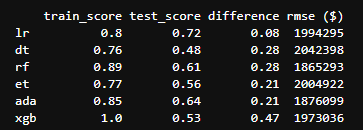

We'll redefine the linear regression model below, using the best parameters determined by the gridsearch above.

In [22]:
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('pc', PCA(
        n_components=37,
        random_state=42)),
    ('lr', LinearRegression())])

In [23]:
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('pc', PCA(n_components=37, random_state=42)),
                ('lr', LinearRegression())])

In [24]:
preds = lr_pipe.predict(X_test)

In [25]:
print(f"Training score: {round(lr_pipe.score(X_train, y_train), 2)}")
print(f"Test score: {round(lr_pipe.score(X_test, y_test), 2)}")
print(f"Difference: {round(lr_pipe.score(X_train, y_train)-(lr_pipe.score(X_test, y_test)), 2)}")
print(f"RMSE: ${int(mean_squared_error(y_test, preds, squared=False))}")

Training score: 0.81
Test score: 0.69
Difference: 0.11
RMSE: $1325521


Having created, trained, and tested our model on forwards data, we can now pickle the model in order to load it in the web app.

In [26]:
with open('../models/forwards_model.pkl', 'wb') as file:
    pickle.dump(lr_pipe, file)

---
#### Notebook Links

Part I - Project Intro & Data Cleaning
- [`Part-1_setup-and-cleaning.ipynb`](../code/Part-1_setup-and-cleaning.ipynb)

Part II - Exploratory Data Analysis (EDA)
- [`Part-2_eda.ipynb`](../code/Part-2_eda.ipynb)

Part III - Modeling
- [`Part-3.2_modeling-defense.ipynb`](../code/Part-3.2_modeling-defense.ipynb)
- [`Part-3.3_modeling-goalies.ipynb`](../code/Part-3.3_modeling-goalies.ipynb)

Part IV - Conclusion, Recommendations, and Sources
- [`Part-4_conclusion-and-recommendations.ipynb`](../code/Part-4_conclusion-and-recommendations.ipynb)